In [208]:
# Import required modules 
import cv2 as cv
import numpy as np
import numpy.typing as npt
import os
from checkerboard import detect_checkerboard

In [209]:
from dataclasses import dataclass

In [210]:
from ImageAnotater import ImageAnnotator
import ipywidgets as widgets

In [211]:
from matplotlib import pyplot as plt

In [212]:
@dataclass
class CameraCalibtationResult():
    ret : bool
    intrinsic_matrix : npt.NDArray
    distortion : npt.NDArray
    r_vecs : npt.NDArray
    t_vecs : npt.NDArray

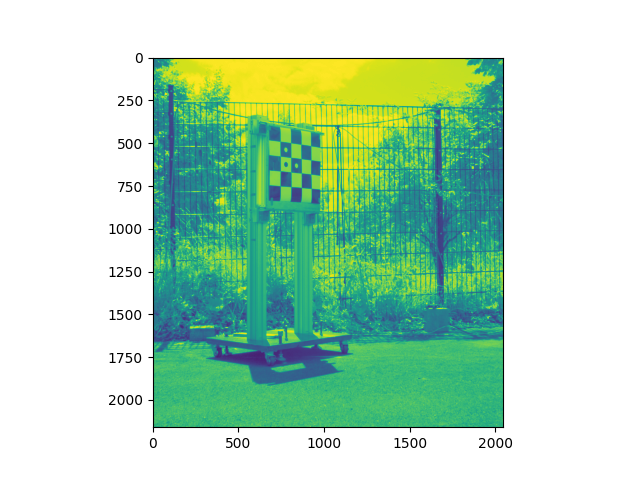

Button(description='Next Image', style=ButtonStyle())

In [214]:
%matplotlib ipympl
image_files = ["test_data/checker_test_001_21649.jpg",
               "test_data/checker_test_001_21656.jpg",
               "test_data/checker_test_001_21657.jpg"]

annotator = ImageAnnotator(image_files)

button = widgets.Button(description="Next Image")
button.on_click(lambda b: annotator.next_image())
annotator.button = button  # Pass the button to the annotator
display(button)

In [215]:
for im, bbox in zip(image_files, bounding_boxes):
    print(im, "\n")
    print(bbox, "\n\n")

test_data/checker_test_001_21649.jpg 

 xmin: 669.9284822538299
 ymin: 387.69801627815514
 widht:303.896103896104
 heigth:484.6753306203075
 


test_data/checker_test_001_21656.jpg 

 xmin: 769.2791316044794
 ymin: 202.24349163104944
 widht:490.90909090909065
 heigth:465.5844007219587
 


test_data/checker_test_001_21657.jpg 

 xmin: 1190.0583523837
 ymin: 258.7369832620989
 widht:374.02597402597394
 heigth:438.3116883116884
 




In [216]:
images = [cv.imread(f,cv.COLOR_BGR2GRAY) for f in image_files]

In [217]:
# use integers only
# rois_ np.s_[ymin: ymin + height, xmin: xmin + width]

rois1 = np.s_[390:850, 670:970]

rois2 = np.s_[200:650, 770:1250]

rois3 = np.s_[200:700, 1200:1580]

rois = [rois1,rois2,rois3]

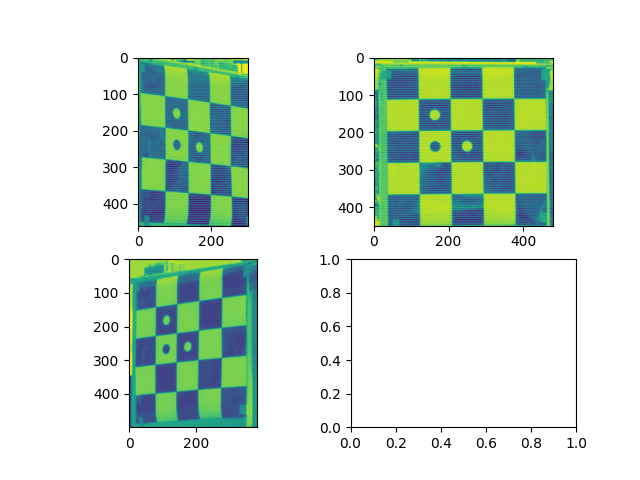

In [218]:
f, axs = plt.subplots(2,2)
for roi, im, ax  in zip(rois,images, axs.flatten()):
    ax.imshow(im[roi])

In [219]:
plt.close("all")

In [220]:
# Define the dimensions of checkerboard 
# this is edges in x and y NOT squares
CHECKERBOARD = (4, 4) 

In [221]:
corners_list = [] # list of detected corner points
scores = [] # list of scores from checkerboard detection
windows = [5,10,8,10] # window sizes of checkerboard detection

for roi, im, win in zip(rois, images, windows):
    corners, score = detect_checkerboard(im[roi],CHECKERBOARD,winsize=win)
    corners_list.append(corners)
    scores.append(score)

In [222]:
scores

[np.float64(0.04371849127599022),
 np.float64(0.008033561435065164),
 np.float64(0.04172637576909641)]

In [223]:
corners.shape

(16, 1, 2)

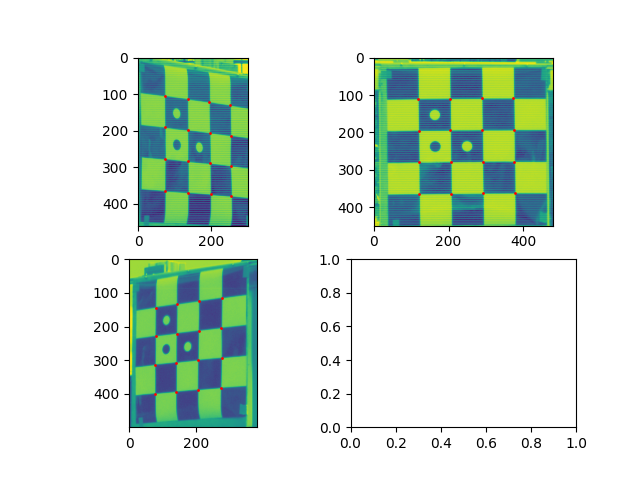

In [224]:
f, axs = plt.subplots(2,2)
for roi, im,c, ax  in zip(rois,images,corners_list, axs.flatten()):
    corners = c #+ np.array([roi[0].start,roi[1].start])
    ax.imshow(im[roi])
    ax.scatter(corners[:,0,0],corners[:,0,1],s=1,c='r')

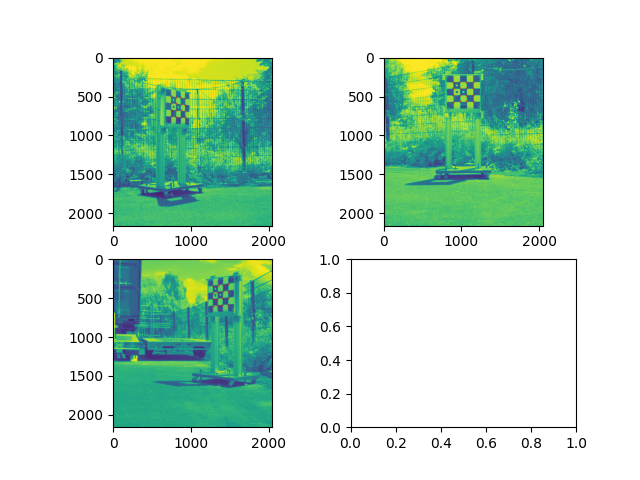

In [225]:
f, axs = plt.subplots(2,2)
original_corners = []
for roi, im,c, ax  in zip(rois,images,corners_list, axs.flatten()):
    corners = c + np.array([roi[1].start,roi[0].start])
    original_corners.append(corners)
    ax.imshow(im)
    ax.scatter(corners[:,0,0],corners[:,0,1],s=0.1,c='r')

In [226]:
#  3D points real world coordinates, theses are the Checker Board Corners 
objectp3d = np.zeros(( CHECKERBOARD[0]  
                      * CHECKERBOARD[1],  
                      3), np.float32) 

In [227]:
for x in range(CHECKERBOARD[0]):
    for y in range(CHECKERBOARD[1]):
        objectp3d[CHECKERBOARD[1]*x+y,:2] = np.array([x,y])

In [228]:
three_d_points = [objectp3d]
camera_calibrations = []
for c,im in zip(original_corners,images):
    two_d_points = [c.astype(np.float32) ]
    ret, matrix, distortion, r_vecs, t_vecs = cv.calibrateCamera( 
                                    three_d_points, 
                                    two_d_points,
                                    im.shape[:2][::-1], # size of the image, since cs graphics its reversed from numpy, just a convention...
                                    None,
                                    None
                                    )
    calib = CameraCalibtationResult(ret = ret,
                                    intrinsic_matrix=matrix,
                                    distortion=distortion,
                                    r_vecs=r_vecs[0],
                                    t_vecs=t_vecs[0])
    camera_calibrations.append(calib)

In [229]:
# print results
print('OpenCV camera model:\n')

def print_camera_calibration(name, calibration):
    print(f'{name}\n'
          f'Intrinsic matrix:\n{calibration.intrinsic_matrix}\n'
          f'Distortion:\n{calibration.distortion}\n'
          f'Rotation vector:\n{calibration.r_vecs}\n'
          f'Translation vector:\n{calibration.t_vecs}\n')

camera_names = ['cam21649', 'cam21656', 'cam21657']
for name, calibration in zip(camera_names, camera_calibrations):
    print_camera_calibration(name, calibration)

print(camera_calibrations)


OpenCV camera model:

cam21649
Intrinsic matrix:
[[4.64724265e+02 0.00000000e+00 1.00399366e+03]
 [0.00000000e+00 7.24801214e+02 9.46268568e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion:
[[ 0.24237234 -0.31636182  0.02559653 -0.03051262  0.17646445]]
Rotation vector:
[[2.16298485]
 [2.19327837]
 [0.07586123]]
Translation vector:
[[-4.42507793]
 [-5.21652304]
 [ 8.7294791 ]]

cam21656
Intrinsic matrix:
[[2.64310055e+04 0.00000000e+00 9.46155164e+02]
 [0.00000000e+00 2.44119552e+04 1.06422724e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion:
[[-5.47846993e+01  7.66579737e+03 -1.01955211e+00  1.42832828e-01
   1.46488216e+01]]
Rotation vector:
[[2.07938834]
 [2.05391865]
 [0.22981512]]
Translation vector:
[[ -0.68753037]
 [ -9.02484191]
 [306.02290845]]

cam21657
Intrinsic matrix:
[[6.04563947e+03 0.00000000e+00 1.03172538e+03]
 [0.00000000e+00 6.53025054e+03 1.09056924e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion:
[[ 7.69417102e+00 -

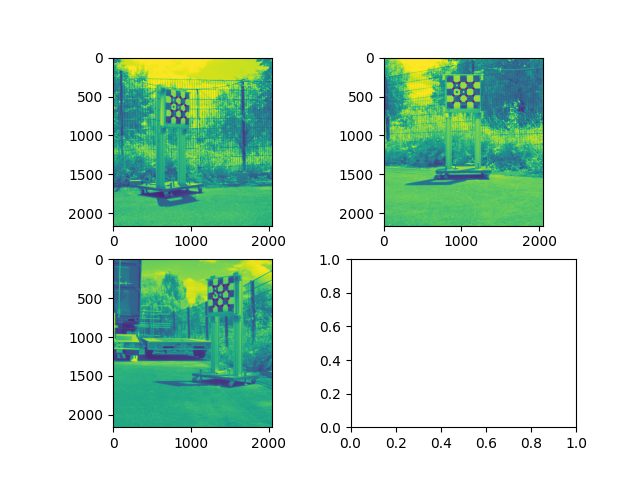

In [230]:
# reprojection:

f,axs = plt.subplots(2,2)
for calib,corners,im,ax in zip(camera_calibrations,original_corners,images,axs.flatten()):
    reprojected_points, jacobian = cv.projectPoints(objectp3d,calib.r_vecs, calib.t_vecs,calib.intrinsic_matrix,calib.distortion)
    ax.imshow(im)
    ax.scatter(reprojected_points[:,0,0],reprojected_points[:,0,1],s=0.2,c='b')
    ax.scatter(corners[:,0,0],corners[:,0,1],s=0.1,c='r')

# What now could be further steps here?
In CV:
- undistort images using [undistort](https://docs.opencv.org/3.1.0/da/d54/group__imgproc__transform.html#ga69f2545a8b62a6b0fc2ee060dc30559d)
- Use [stereocalibrate](https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#stereocalibrate) to calibrate the cameras pairwise
- rectify images to make matching easiert using [stereoRectify](https://docs.opencv.org/3.1.0/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6)
- match points in the rectified image using suitable tools, make use of the fact that epi polar lines are paralel in the images now. The epi lines can be found using [computeCorrespondEpilines](https://docs.opencv.org/3.1.0/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7). This
- use the projection matrices returned by retify to project back to 3d using [triangulatepoints](https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#triangulatepoints)

In [231]:
import math
# parameters breakdown
# convert to values in L3PT codes

# define the function to convert rotation vectors to rotation matrices
def rotation_vectors_to_matrices(r_vecs):
    r_matrices = []
    for r_vec in r_vecs:
        r_matrix, _ = cv.Rodrigues(r_vec) # see Rodrigues() from openCV
        r_matrices.append(r_matrix)
    return r_matrices

# extraction of Euler Angles
# assuming the angles are in radians.
# chatGPT wrote this - check that r_matrix cannot be singular
def r_matrix_to_euler_angles(R): 
    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6
    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0
    return np.array([x, y, z])

In [233]:
print('L3PT camera model:\n')

# for each camera:
for i, calib in enumerate(camera_calibrations):
    intrinsic_matrix = calib.intrinsic_matrix
    distortion = calib.distortion
    r_vecs = calib.r_vecs
    t_vecs = calib.t_vecs

    # rotation matrix and euler angles
    r_matrices = rotation_vectors_to_matrices([r_vecs]) 
    r_matrix = r_matrices[0]
    euler_angles = r_matrix_to_euler_angles(r_matrices[0])
    angle_x = euler_angles[0]
    angle_y = euler_angles[1]
    angle_z = euler_angles[2]
   
    # optical center (cx, cy) in px coordinates
    cx = intrinsic_matrix[0][2]
    cy = intrinsic_matrix[1][2]
    # skew coefficients
    skew_sc = intrinsic_matrix[0][1]
    
    # translation vector components
    trnsl_x = t_vecs[0]
    trnsl_y = t_vecs[1]
    trnsl_z = t_vecs[2]
    
    # 1st & 2nd distortion coeff
    k1 = distortion[0,0]
    k2 = distortion[0,1]

    #TODO:
    # m_y/m_x
    # magnf_x

    print(f"camera {i+1}\n")
    print(f"angle_x: {angle_x}")
    print(f"angle_y: {angle_y}")
    print(f"angle_z: {angle_z}")
    print(f"cx: {cx}")
    print(f"cy: {cy}")
    print(f"k1: {k1}")
    print(f"k2: {k2}")
    print(f"skew_sc: {skew_sc}")
    print(f"trnsl_x: {trnsl_x}")
    print(f"trnsl_y: {trnsl_y}")
    print(f"trnsl_z: {trnsl_z}")

    print(f"magnf_x: no idea what this is")
    print(f"m_y/m_x: typically 1")
    
    print()

L3PT camera model:

camera 1

angle_x: 3.0642356649357474
angle_y: 0.008320727603303444
angle_z: 1.5843821362302393
cx: 1003.9936576619428
cy: 946.2685676860307
k1: 0.24237234182057155
k2: -0.31636181740915925
skew_sc: 0.0
trnsl_x: [-4.42507793]
trnsl_y: [-5.21652304]
trnsl_z: [8.7294791]
magnf_x: no idea what this is
m_y/m_x: typically 1

camera 2

angle_x: 2.8821658296704435
angle_y: 0.03595477239411445
angle_z: 1.553781714546724
cx: 946.155164244627
cy: 1064.2272386047666
k1: -54.78469929531039
k2: 7665.797370418406
skew_sc: 0.0
trnsl_x: [-0.68753037]
trnsl_y: [-9.02484191]
trnsl_z: [306.02290845]
magnf_x: no idea what this is
m_y/m_x: typically 1

camera 3

angle_x: -2.334201557583473
angle_y: -0.06638530507594637
angle_z: 1.5308265040609517
cx: 1031.7253761082916
cy: 1090.569244359707
k1: 7.69417101936585
k2: -100.2087685547773
skew_sc: 0.0
trnsl_x: [2.82062334]
trnsl_y: [-8.78320498]
trnsl_z: [75.55078727]
magnf_x: no idea what this is
m_y/m_x: typically 1

